In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data, cumulative_days_in_months
import calendar
from matplotlib.colors import ListedColormap, BoundaryNorm

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "2m_temperature"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

2024-12-04 13:33:20,913 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-04 13:33:20,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-04 13:33:20,913 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-04 13:33:20,914 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.


{'variable': ['2m_temperature'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-04 13:33:21,106 INFO Request ID is 7ad52f90-91d7-4054-974a-57cf8e1d4cbc
2024-12-04 13:33:21,165 INFO status has been updated to accepted
2024-12-04 13:33:22,222 INFO status has been updated to running
2024-12-04 13:33:26,096 INFO status has been updated to successful
                                                                                         

Retrieving data in to:  2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the daily temperature climatology
def temperatureDailyClimatology():
    """
    Calculate the daily climatology of minimum and maximum temperatures.
    This function reads temperature data from a NetCDF file, converts the time 
    coordinate to a pandas datetime index, and processes the data to find daily 
    minimum and maximum temperatures. It then calculates the climatological 
    mean of these daily minimum and maximum temperatures for each day of the year.
    Returns:
        pd.DataFrame: A DataFrame with the climatological mean of daily minimum 
                      and maximum temperatures, indexed by month and day.
    """

    data_t2m_pt = xr.open_dataset(data_file).t2m

    # Convert the time coordinate to a pandas datetime index
    time_index = pd.to_datetime(data_t2m_pt.valid_time.values)

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(data_t2m_pt.values, index=time_index, columns=['t2m'])

    # Convert temperatures from Kelvin to Celsius
    df['t2m'] -= 273.15

    # Resample to find daily minimum and maximum
    daily_min = df.resample('D').min()
    daily_max = df.resample('D').max()

    # Combine the daily min and max into a single DataFrame
    daily_stats = pd.DataFrame({
        'daily_min': daily_min['t2m'],
        'daily_max': daily_max['t2m']
    })

    # Extract month and day from DateTimeIndex
    daily_stats['month'] = daily_stats.index.month
    daily_stats['day'] = daily_stats.index.day

    # Group by month and day
    grouped_by_dayofyear = daily_stats.groupby(['month', 'day'])

    # Calculate means (of the min and maxs)
    daily_minmax_clim = grouped_by_dayofyear.mean()

    return daily_minmax_clim

# Call our function
clim = temperatureDailyClimatology()

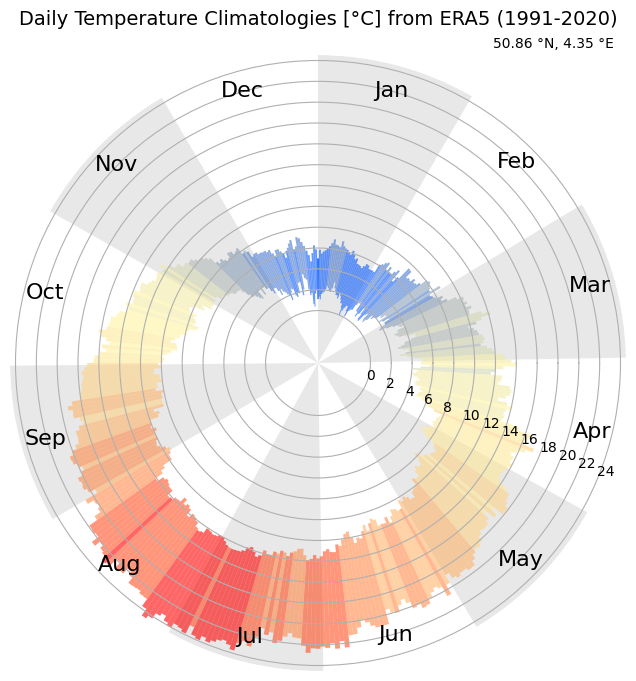

In [3]:
latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Custom colors
dailyPolarColors = [
    "#0055ff", "#4376ce", "#859bb4", "#b1bab8", "#d3d7b2",
    "#f2eaa3", "#fff29e", "#fee996", "#fed383", "#ffb369",
    "#ff8949", "#ff4e21", "#ff0000"
]

cumulative_days = cumulative_days_in_months()

# Convert month to radians for the polar plot
angles = np.linspace(0, 2 * np.pi, len(clim), endpoint=False)

# Ensure the plot closes the loop
angles = np.append(angles, angles[0])
daily_min = np.append(clim['daily_min'].values, clim['daily_min'].values[0])
daily_max = np.append(clim['daily_max'].values, clim['daily_max'].values[0])

# Calculate the height of each bar (difference between daily_max and daily_min)
heights = daily_max - daily_min

# Find the minimum value in the data
ylim0 = min(daily_min) - 5
ylim1 = max(daily_max)
min_of_daily_max = min(daily_max)

# Define the range and colormap
cmap = ListedColormap(dailyPolarColors)
norm = BoundaryNorm(
    boundaries=np.linspace(min_of_daily_max - 0.01, ylim1 + 0.01, len(dailyPolarColors) + 1),
    ncolors=len(dailyPolarColors),
    clip=True
)

# Map data to colors (clamping values outside the range)
colors = cmap(norm(np.clip(daily_max, min_of_daily_max, ylim1)))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_frame_on(False)

# Set the direction to clockwise
ax.set_theta_direction(-1)

# Set radial axis range (5 units below the lowest value)
ax.set_ylim(ylim0, ylim1)

# Add labels
ax.set_xticks([])
ax.set_yticks(range(0, int(max(daily_max)) + 2, 2))

# Shade alternate segments (30 degrees wide) with curved edges
for (index, nDays) in enumerate(cumulative_days):  # 360 degrees, step of 30 degrees
    # Start and end angles for each segment (in radians)
    previous_nDays = cumulative_days[index - 1] if index > 0 else 0
    width = nDays - previous_nDays
    mid_angle = np.deg2rad(nDays * 360 / 366) - np.pi / 2
    start_angle = mid_angle - np.deg2rad(width / 2)

    # Add the month label inside the shaded segment
    ax.text(start_angle, 0.9 * ylim1, month_names[index], horizontalalignment='center', verticalalignment='center', fontsize=16)

    if (index % 2) == 1: continue

    # Create a curved shading segment by filling between the radial axis
    ax.bar(x=start_angle, bottom=ylim0, height=ylim1-ylim0, width=2 * np.pi / 12, color='lightgray', alpha=0.5)

# Plot bars
bars = ax.bar(angles - np.pi / 2, heights, width=2 * np.pi / len(clim), bottom=daily_min, color=colors,
              alpha=0.6, label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}')

# Add legend and title
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0, handlelength=0)
plt.title(f'Daily Temperature Climatologies [°C] from {ERA_VERSION} ({date_range[0][:4]}-{date_range[1][:4]})\n', fontsize=14)

plt.show()